<a href="https://colab.research.google.com/github/anthonyckleung/HR-Churn-Analysis/blob/master/hr_churn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Employee Churn Analysis

**Description**
Employee turn-over (also known as "employee churn") is a costly problem for companies. The cost of replacing employees for most employers remains significant. This is due to the amount of time spent to interview and find a replacement, sign-on bonuses, and the loss of productivity for several months while the new employee gets accustomed to the new role.

**Problem Statement**
Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as possibly planning new hiring in advance. 

In this study, we will attempt to solve the following problem statement is:

* Create a model that can predict the likelihood of employee churn.
* What are the key indicators of an employee leaving the company?

Given that we have data on former employees, this is a standard supervised classification problem where the label is a binary variable, 0 (active employee), 1 (former employee). In this study, our target variable Y is the probability of an employee leaving the company.

**Features**
- satisfaction_level: It is employee satisfaction point, which ranges from 0-1.
- last_evaluation: It is evaluated performance by the employer, which also ranges from 0-1.
- number_projects: How many numbers of projects assigned to an employee?
average_monthly_hours: How many average numbers of hours worked by an employee in a month?
- time_spent_company: time_spent_company means employee experience. The number of years spent by an employee in the company.
- work_accident: Whether an employee has had a work accident or not.
promotion_last_5years: Whether an employee has had a promotion in the last 5 years or not.
- Departments: Employee's working department/division.
- Salary: Salary level of the employee such as low, medium and high.
- churn: Whether the employee has left the company or not.

# Import Libraries

In [ ]:
!pip install shap

In [ ]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import shap

plt.rcParams['figure.facecolor'] = 'w' # For Colab in dark mode
sns.set()
#current_palette = sns.color_palette("cubehelix")
#current_palette = sns.color_palette("Paired")
#sns.set_palette(current_palette)

# Specify the custom font to use

plt.rcParams["axes.labelweight"] = "bold"

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, LearningCurveDisplay
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import classification_report

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount = False)

Mounted at /content/gdrive/


# Exploratory Data Analysis

In [ ]:
# Data file path
path = '/content/gdrive/MyDrive/Colab Notebooks/1000ML/Unit2_Classification/Projects/HR Data/hr-data.csv'

In [88]:
df = pd.read_csv(path)

In [89]:
df.head()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,low
1,1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,3,0.72,0.87,5,223,5,0,1,0,sales,low
4,4,0.37,0.52,2,159,3,0,1,0,sales,low


In [90]:
df.shape

(14999, 11)

In [91]:
# Check if there are any duplicated employee ids
df['id'].duplicated().any()

False

**OBSERVATIONS**: There are no duplicated ids.

In [92]:
# Set the id column as index
df = df.set_index(['id'])
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [ ]:
# Why is there a column called "Sales"??

df['sales'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

**Note**: Looks like a typo where `sales` should have been "departments" instead.

In [ ]:
df = df.rename(columns={"sales": "dept"})

In [ ]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


 Check if there are any null entries

In [ ]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
churn                    0
promotion_last_5years    0
dept                     0
salary                   0
dtype: int64

**OBSERVATIONS**: No null entries.

What is the distribution of employee count by departments look like?

Text(0, 0.5, 'Employee Count')

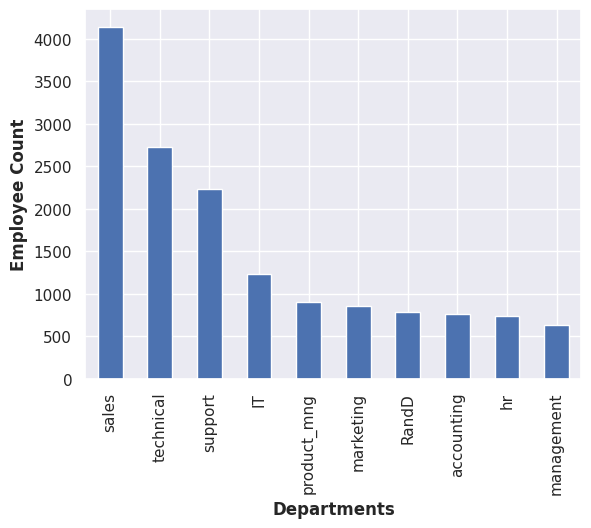

In [ ]:
df['dept'].value_counts().plot(kind='bar')
plt.xlabel("Departments")
plt.ylabel("Employee Count")

In [ ]:
df['dept'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: dept, dtype: int64

**OBSERVATIONS**: About 27% of employees in this company are from sales.

([<matplotlib.axis.XTick at 0x7f6e70614b50>,
 [Text(0, 0, 'No Churn'), Text(1, 0, 'Churn')])

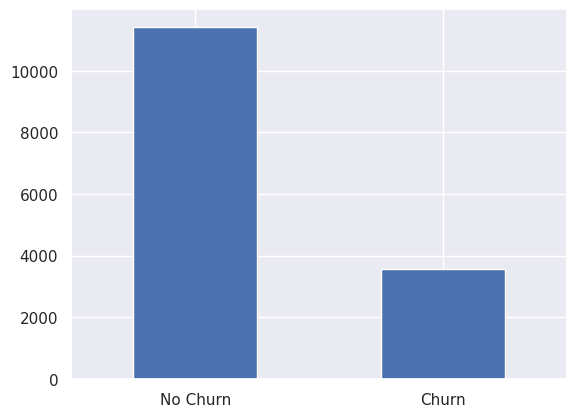

In [ ]:
# Look at the distribution of the target class: Churn
df['churn'].value_counts().plot(kind='bar')
plt.xticks((0,1),('No Churn', 'Churn'), rotation=0)

In [ ]:
df['churn'].value_counts()

0    11428
1     3571
Name: churn, dtype: int64

**OBSERVATIONS**: We can see an imbalance of target classes in this data set (76% No Churn; 24% Churn)

Look at how churning is distributed among different departments./

<Axes: xlabel='dept', ylabel='count'>

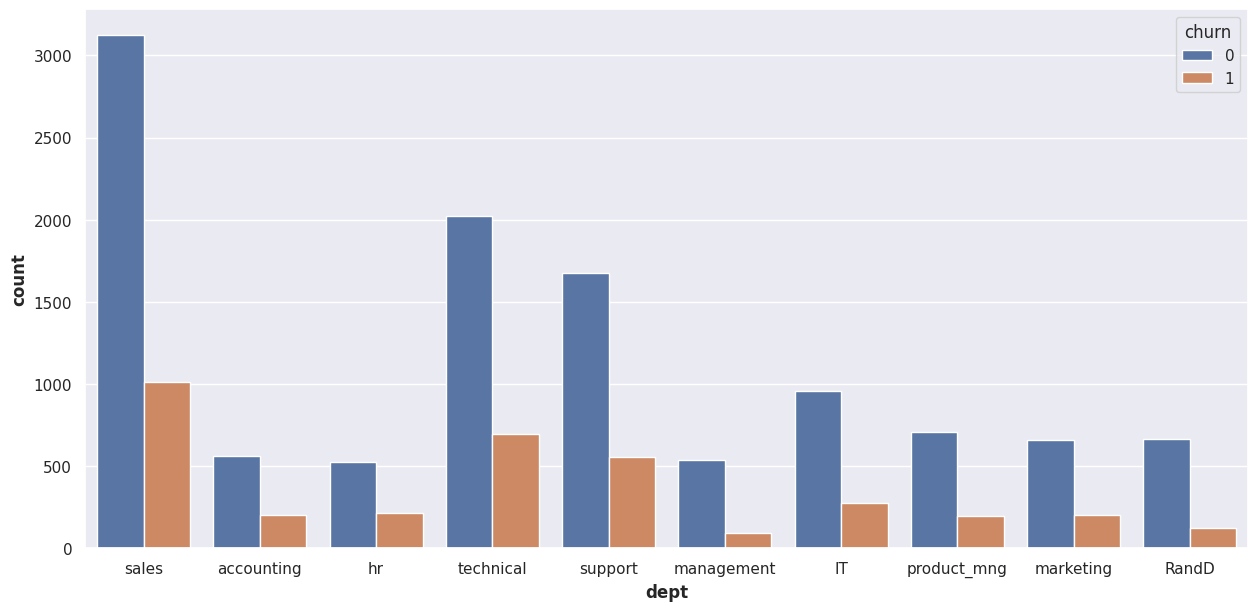

In [ ]:
plt.figure(figsize = (15, 7))
sns.countplot(x = 'dept' ,hue ='churn',data= df)

**OBSERVATIONS**: Top 3 departments where people have churned are from techinical, support, and sales.

Text(0.5, 0, 'Satisfaction Level')

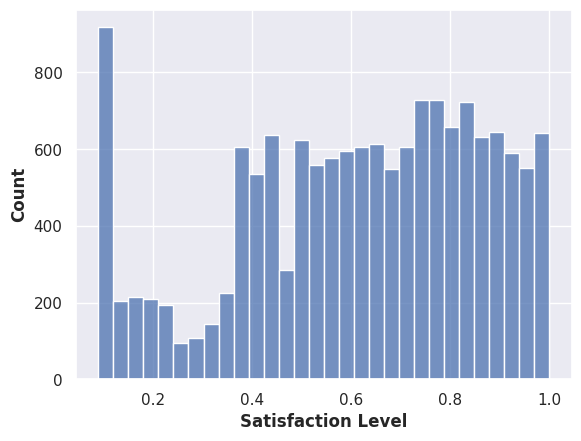

In [ ]:
# Look at the distribution of satisfaction levels
sns.histplot(df['satisfaction_level'])
plt.xlabel('Satisfaction Level')

**OBSERVATIONS**: A wide range of satisfaction from employees. A high count of over 800 employees indicated a satisfaction level of <0.1.

# Preprocessing

We note that the categorical variables of `sales` and `salary` need to be encoded.

Dummy the `dept` variable.

In [ ]:
df = pd.get_dummies(df, prefix='dept', columns=['dept'])

In [ ]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

Map the salary descriptive levels by numeric levels

In [ ]:
salary_dict = {'low':-1, 'medium':0, 'high':1}
df['salary'] = df['salary'].map(salary_dict)

In [ ]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,salary,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical
id,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,-1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,-1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,-1,0,0,0,0,0,0,0,1,0,0


Separate the features and the target class.

In [ ]:
df.columns.tolist()

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'churn',
 'promotion_last_5years',
 'salary',
 'dept_IT',
 'dept_RandD',
 'dept_accounting',
 'dept_hr',
 'dept_management',
 'dept_marketing',
 'dept_product_mng',
 'dept_sales',
 'dept_support',
 'dept_technical']

In [ ]:
input_var = [
     'satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years',
 'salary',
 'dept_IT',
 'dept_RandD',
 'dept_accounting',
 'dept_hr',
 'dept_management',
 'dept_marketing',
 'dept_product_mng',
 'dept_sales',
 'dept_support',
 'dept_technical'
]

output_var = ['churn'] 

In [56]:
X = df[input_var]
y = df[output_var]

Train-test split data

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Standardize the columns the values of which are out of 0-1 range (Not needed for logistic + RF)
# scaler = StandardScaler().fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# Model Search

In [59]:
# Create a list of models

models = []
models.append(('Logistic Regression', LogisticRegression(random_state=42)))
models.append(('Logistic Regression (Weight Balanced)', LogisticRegression(random_state=42,
                                                         class_weight='balanced')))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)))
models.append(('Random Forest', RandomForestClassifier(random_state=42)))


In [ ]:
acc_results = []
auc_results = []
names = []

# Set dataframe to populate performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']
model_results_df = pd.DataFrame(columns=col)
i = 0

# Evaluate each model using cross-validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)  # 10-fold cross-validation

    cv_acc_results = cross_val_score(  # accuracy scoring
        model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = cross_val_score(  # roc_auc scoring
        model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results_df.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1


In [61]:
model_results_df.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
3,Random Forest,99.41,0.27,99.08,0.20
2,Decision Tree Classifier,97.64,0.45,98.00,0.35
1,Logistic Regression (Weight Balanced),82.67,1.02,75.48,1.06
0,Logistic Regression,81.83,1.22,79.15,1.27


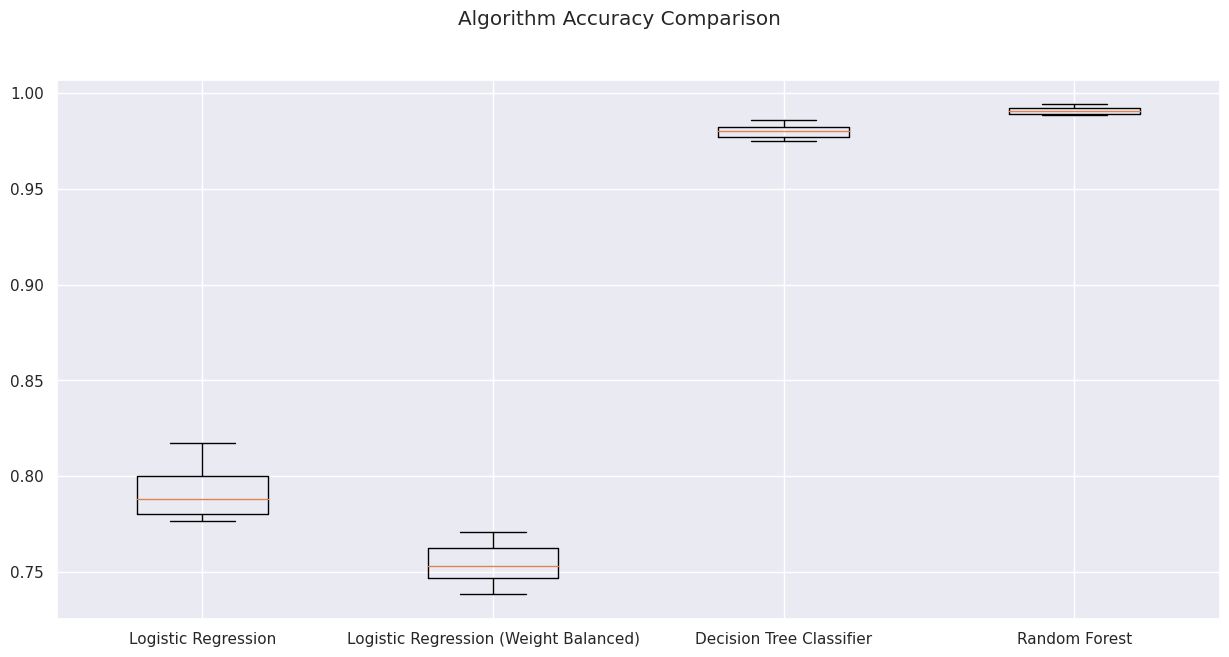

In [62]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.show()

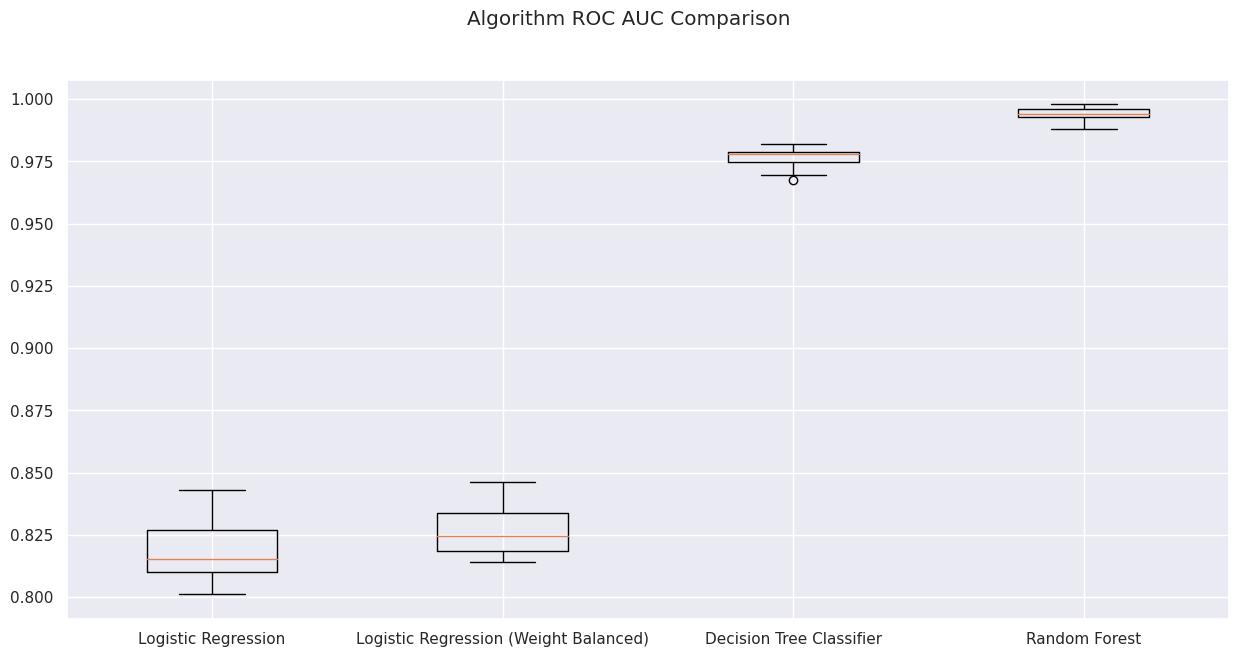

In [63]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Algorithm ROC AUC Comparison')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.show()

**OBSERVATIONS**: From model search, tree classifier produced an accuracy and AUC score of over 0.8, higher than logistic regression.

Move forward with random forest classifier for fine-tuning.

# Random Forest Classifier: Fine-Tuning

In [64]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42,n_jobs=-1)

In [ ]:
param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

# grid_obj = GridSearchCV(rf_model,
#                         return_train_score=True,
#                         param_grid=param_grid,
#                         scoring='roc_auc',
#                         cv=10)

grid_obj = RandomizedSearchCV(rf_model,
                        return_train_score=True,
                        param_distributions=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_



In [66]:

print("Best params: " + str(grid_obj.best_estimator_))
print("Best params: " + str(grid_obj.best_params_))
print('Best score:', grid_obj.best_score_)


Best params: RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=150, n_jobs=-1, random_state=42)
Best params: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15}
Best score: 0.9930835664099942


In [67]:
y_pred = rf_opt.predict(X_test)

In [68]:
print(classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn']))

              precision    recall  f1-score   support

   Not Churn       0.98      1.00      0.99      2294
       Churn       0.99      0.94      0.96       706

    accuracy                           0.98      3000
   macro avg       0.98      0.97      0.98      3000
weighted avg       0.98      0.98      0.98      3000



**OBSERVATIONS**: The optimized RF classifier (with balanced weights) gave a ROC AUC score of 0.99, F1-Scores are over 0.95 with randomized search cv.

Model Complexity - Under/Overfitting?

In [69]:
common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": 10,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

In [70]:
rf_clf = RandomForestClassifier(n_estimators=75, 
                                min_samples_split=6, 
                                min_samples_leaf=2, 
                                max_depth=20, 
                                class_weight='balanced', 
                                random_state=42,
                                n_jobs=-1)

Text(0.5, 1.0, 'Learning Curve for RandomForestClassifier')

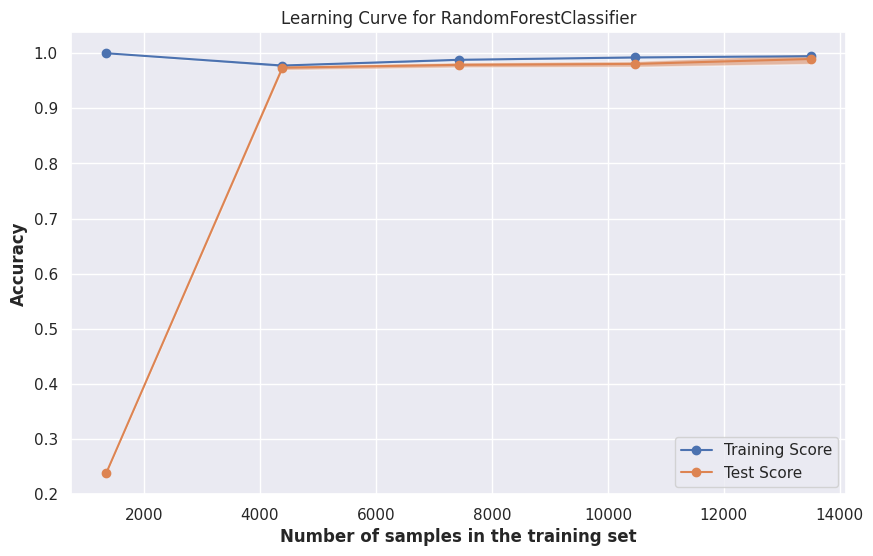

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

LearningCurveDisplay.from_estimator(rf_clf, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {rf_clf.__class__.__name__}")

**OBSERVATIONS**: No indication of under/overfitting as the training and testing curves converged.

Let us now examine the characteristics that would explain how the random forest classifier determines whether a given employee will churn not. Turn to Shapley analysis.

# Shapley Analysis

In [72]:
# Extract a portion of the X set for shap analysis
X_shap = X.sample(n=300, random_state = 42)
feat_columns = X.columns.tolist()

explainer = shap.TreeExplainer(rf_opt)
shap_values = explainer.shap_values(X_shap)

Start with the summary plot showing the feature importance.

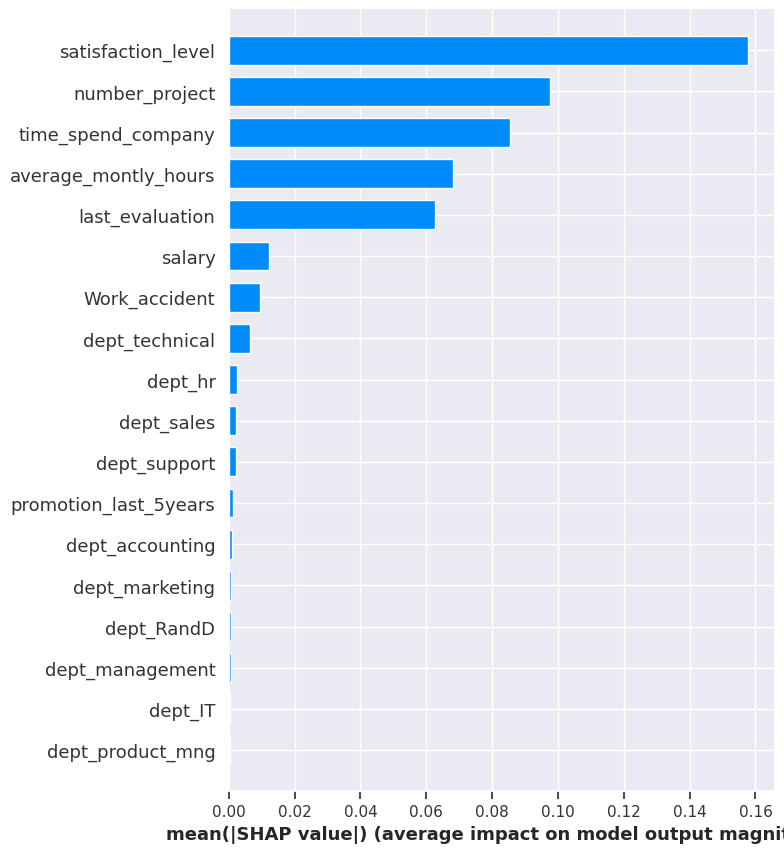

In [73]:
shap.summary_plot(shap_values[1], X_shap, plot_type="bar")

**OBSERVATIONS**: From the summary plot above, the top 5 attributes that affects the model decision are:
* Satisfaction level
* Number of projects
* Time spend with company
* Last Evaluation
* Avg monthly hours

Look at the shap values plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


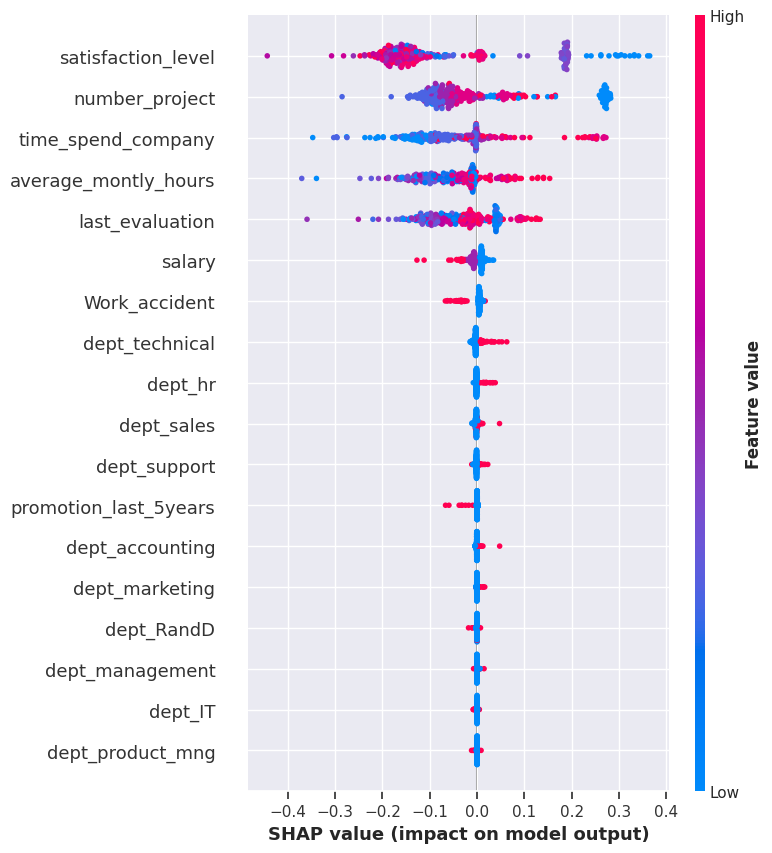

In [74]:
shap.summary_plot(shap_values[1],
                  X_shap,
                  feature_names = feat_columns)

**OBSERVATIONS**: From the SHAP values, look at how the range of values of the top 5 attributes:
* Satisfaction level: The lower the satisfaction, the more likely employee will churn.
* Number of projects: Mixed observations here. There can be both cases where fewer/more projects can lead to employee churn.
* Time spend at company: Longer time stay could lead to employee churn.
* Last evaluation: High evaluation scores could also lead to churning. Note that high evaluation scores are associated with high performers.
* Avg. monthly hours: The longer hours spent at the company working per month, the more likely it leads to employee churn. There are also exceptional cases where fewer hours can lead to employee churn.

Since we are interested to keep high-performers, let us see how each of the above attributes interact with `last_evaluation`.

## Interaction: `last_evaluation`

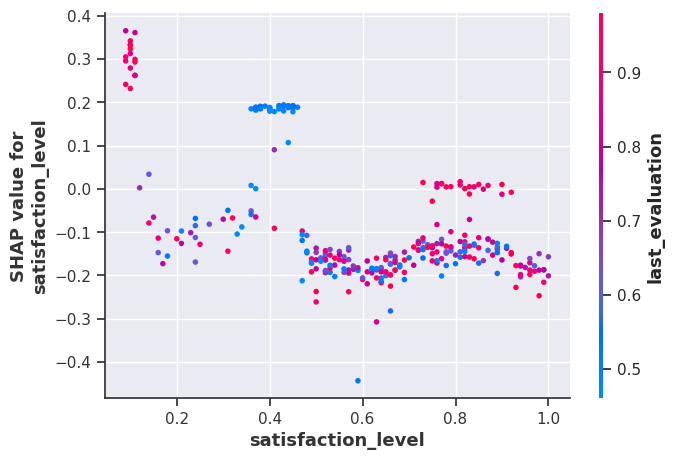

In [75]:
shap.dependence_plot('satisfaction_level',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'last_evaluation',
                     )

**OBSERVATIONS**: There are very specific satisfaction levels which drives one to churn: 
* Below 0.2.
* Around 0.4
* Around 0.8.

Many of the high-performers who are rated their satisfaction level to be < 0.2 have a high tendency to churn. 

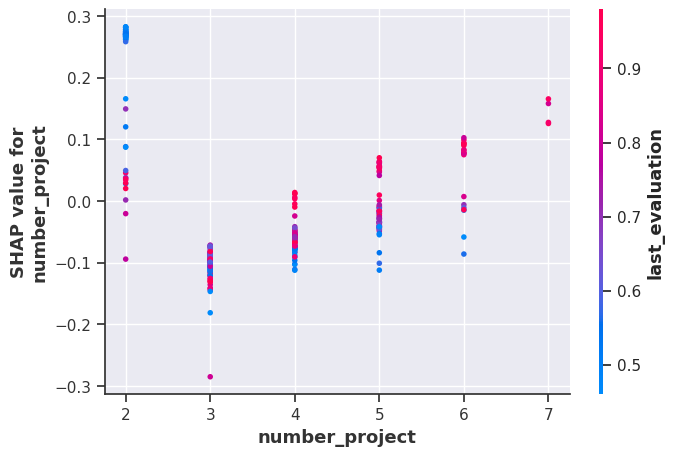

In [76]:
shap.dependence_plot('number_project',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'last_evaluation',
                     )

**OBSERVATIONS**: In general, more projects can lead to higher chance of churning. There is are specific case where those that have only 2 projects can also lead to churning but they are not associated with high-performers.

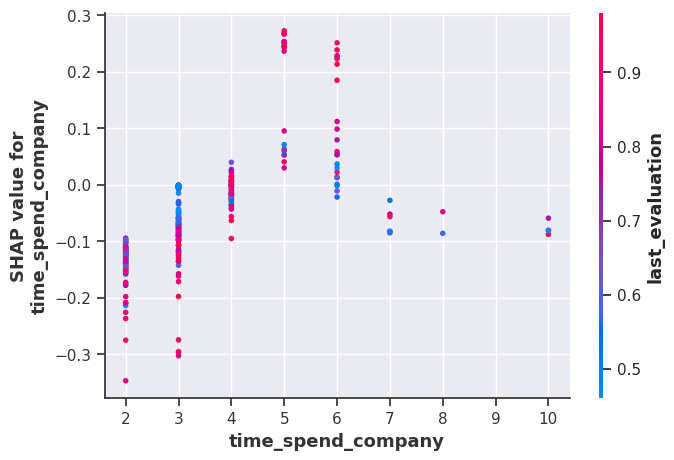

In [77]:
shap.dependence_plot('time_spend_company',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'last_evaluation',
                     )

**OBSERVATIONS**: It seems that once employees hit around the 5 to 6 years mark, there is a very high chance high-performers will leave the company. 

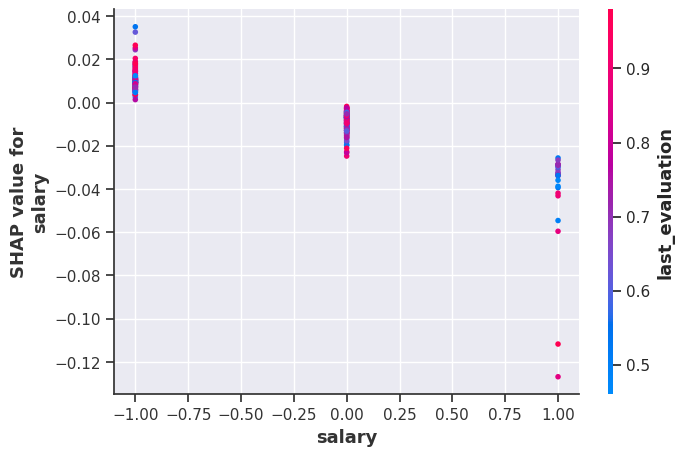

In [78]:
shap.dependence_plot('salary',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'last_evaluation',
                     )

**OBSERVATIONS**: As expected, those associated with lower salaries have the tendency to leave the company. Also, many of the reported low salaries are associated with high-performers 

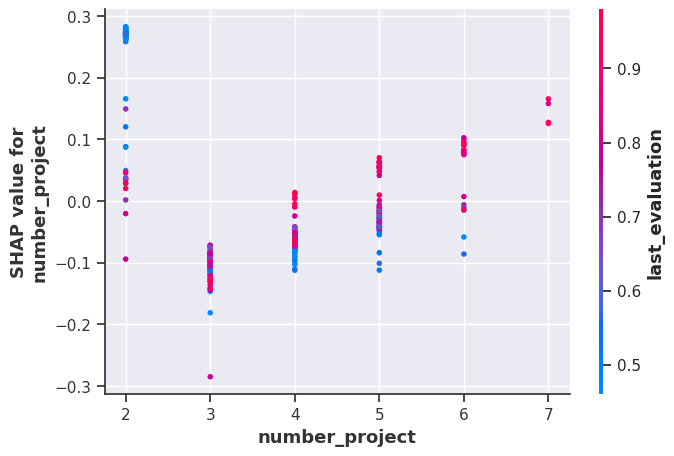

In [79]:
shap.dependence_plot('number_project',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'last_evaluation',
                     )

**OBSERVATIONS**: There is some indication that when assigned to multiple projects that requires long hours, this can lead to employee churn. The likelihood of this happening increases with high-performers.

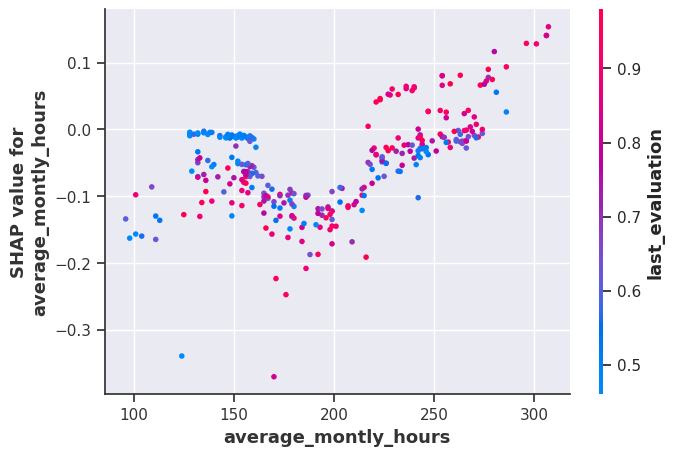

In [80]:
shap.dependence_plot('average_montly_hours',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'last_evaluation',
                     )

**OBSERVATIONS**: High average work hours increases the chance of employee churn. This is more evident with high-performers.

## Interaction_index = `satisfaction_level`

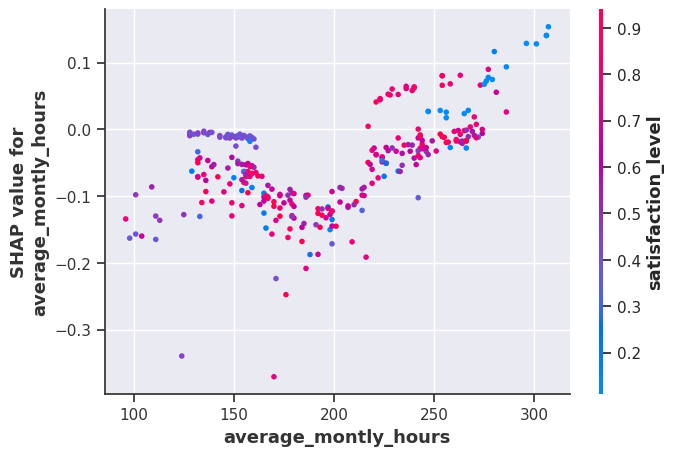

In [81]:
shap.dependence_plot('average_montly_hours',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'satisfaction_level',
                     )

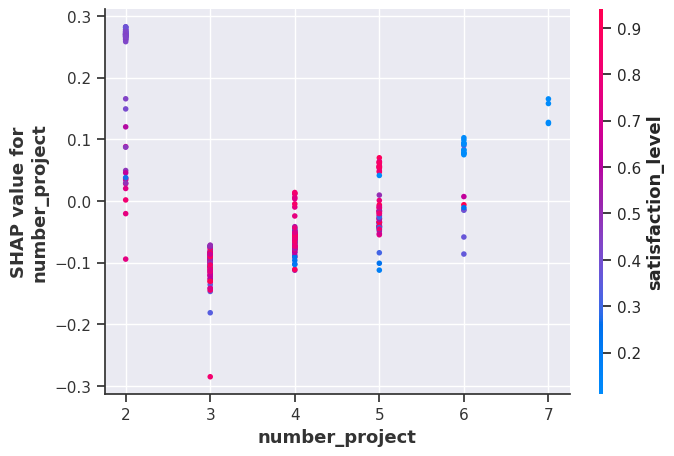

In [82]:
shap.dependence_plot('number_project',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'satisfaction_level',
                     )

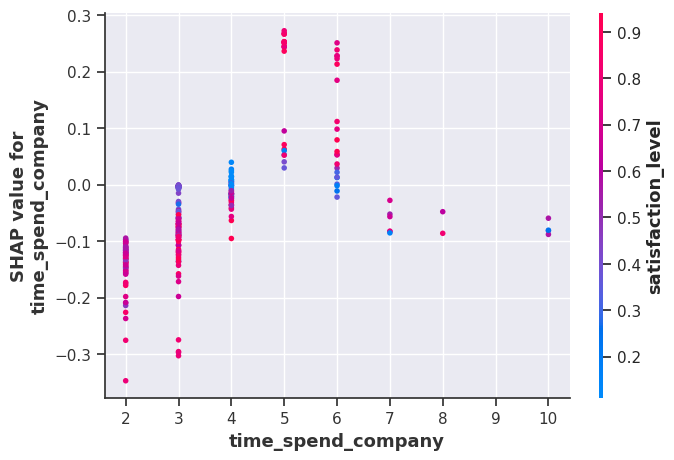

In [83]:
shap.dependence_plot('time_spend_company',
                     shap_values[1],
                     features = X_shap,
                     feature_names = feat_columns,
                     interaction_index = 'satisfaction_level',
                     )

# Summary

Various factors in this company can cause high-performers to churn:

1. Large number of projects assigned.
2. Low salary, compared with low-performers.
3. High working hours per month.
4. Spent about 5 or 6 years at the company.

Many of the above factors are associated with low satisfaction level such as #1 and #3.